In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from statsmodels.duration.hazard_regression import PHReg

import re

%pylab inline

import seaborn as sns
sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


C:\Users\namqb\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#Lifelines stuff
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import pairwise_logrank_test

kmf = KaplanMeierFitter()

In [3]:
ups = pd.read_csv('./Data/ups.txt', sep='\t', index_col=0)

In [4]:
#Restricting to lower limb 
ups = ups[(ups['Year of diagnosis'] >= 1998) & (ups['Year of diagnosis'] <= 2015) & ups['Primary Site - labeled'].map(lambda x: 'lower limb' in x)]

#Restrcting to Localized Only
ups = ups[ups['SEER historic stage A'] == 'Localized']

In [5]:
#Filtering Steps
ups['age'] = ups['Age recode with single ages and 85+'].map(lambda x: int(re.match('[0-9]+', x).group(0)))
ups = ups[ups.age>=18]

#Survival DF
filt_ups = ups[ups['Survival months'] != 'Unknown']
filt_ups['Survival_months'] = filt_ups['Survival months'].astype(int)
filt_ups['censored'] = filt_ups['Vital status recode (study cutoff used)'].map({'Dead':1, 'Alive':0})

## Analysis

(18, 85)

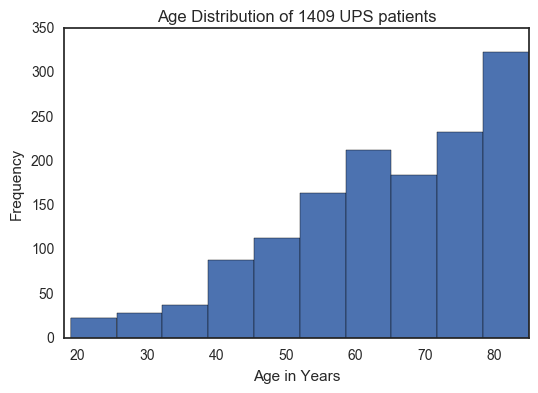

In [117]:
ups.age.plot(kind='hist')
plt.xlabel('Age in Years')
plt.title('Age Distribution of ' + str(len(ups.age)) + ' UPS patients')
plt.xlim([18, 85])

(1998, 2013)

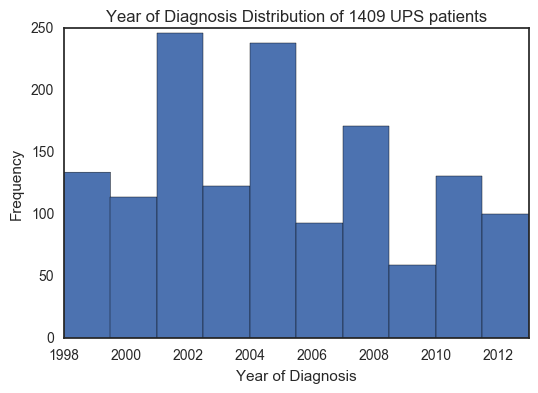

In [118]:
ups['Year of diagnosis'].plot(kind='hist')

plt.xlabel('Year of Diagnosis')
plt.title('Year of Diagnosis Distribution of ' + str(len(ups.age)) + ' UPS patients')

plt.xlim([1998, 2013])

C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


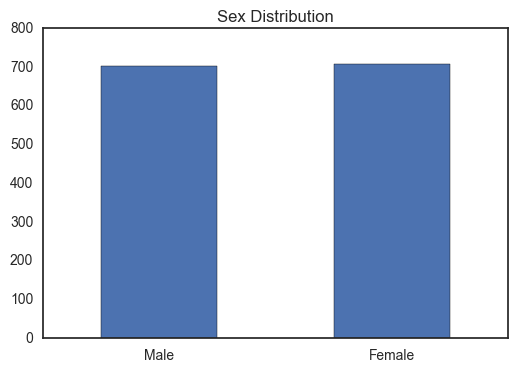

In [119]:
ups.Sex.value_counts().order().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Sex Distribution')

In [120]:
def mapLocation(line):
    line = line.lower()
    if 'lower limb' in line:
        return 'Lower Extremity'
    elif ('upr limb' in line) | ('upper limb' in line):
        return 'Upper Extremity'
    elif ('neck' in line) | ('face' in line) | ('ear' in line):
        return 'Head and Neck'
    elif ('thorax' in line):
        return 'Thorax'
    elif 'lung' in line:
        return 'Lung'
    elif ('pelvis' in line) | ('pelvic' in line):
        return 'Pelvis'
    elif 'retroperitoneum' in line:
        return 'Retroperitoneum'
    elif 'trunk' in line:
        return 'Trunk'
    elif ('abdomen' in line) | ('peritoneum' in line):
        return 'Abdomen'
    else:
        return 'Other'

In [121]:
location_vc = ups['Primary Site - labeled'].map(mapLocation).value_counts()

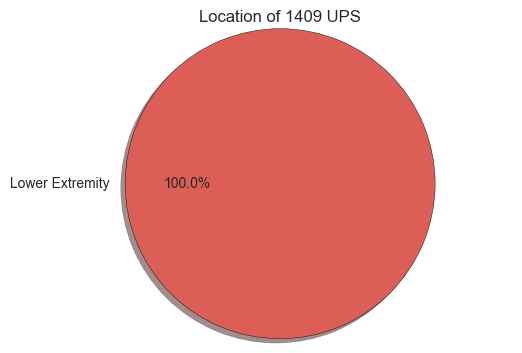

In [122]:
labels = location_vc.index.values
fracs = location_vc.values
colors = sns.color_palette("hls", 10)

pie(fracs, labels=labels, shadow=True, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Location of ' + str(sum(fracs)) + ' UPS')

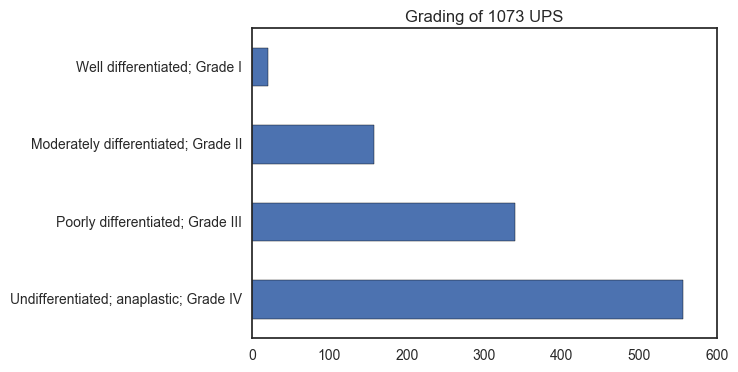

In [123]:
grade_vc = ups.Grade.value_counts().drop('Unknown')

grade_vc.plot(kind='barh')
plt.title('Grading of ' + str(grade_vc.sum()) + ' UPS')

In [124]:
tumor_size = ups[ups['CS tumor size (2004+)'] != 'Blank(s)']['CS tumor size (2004+)'].astype(int)

C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


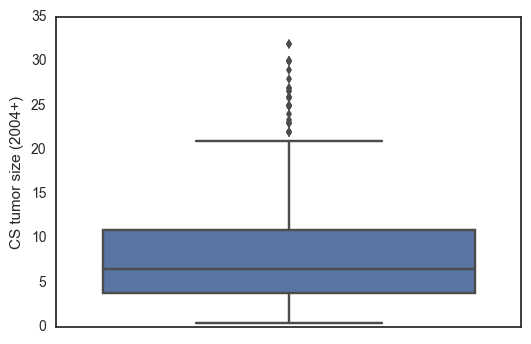

In [125]:
sns.boxplot((tumor_size[tumor_size < 500].order()/10), orient='v')

C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


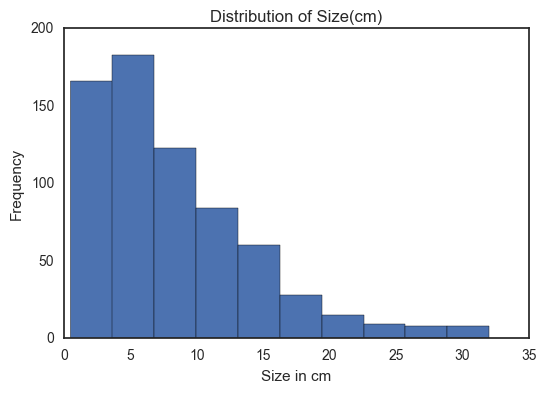

In [126]:
(tumor_size[tumor_size < 500].order()/10).plot(kind='hist')

plt.xlabel('Size in cm')
plt.title('Distribution of Size(cm)')

In [136]:
concat_t_stage = (ups['Derived AJCC T, 7th ed (2010+)'] + ups['Derived AJCC T, 6th ed (2004+)'] + ups['T value - based on AJCC 3rd (1988-2003)']).dropna()

def getTStage(line):
    if line == np.nan:
        return np.nan
    m = re.match('.*(T[0-9]).*', line)
    if m == None:
        return np.nan
    else:
        return m.group(1)
    
t_stage_map = concat_t_stage.map(getTStage).dropna()

C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


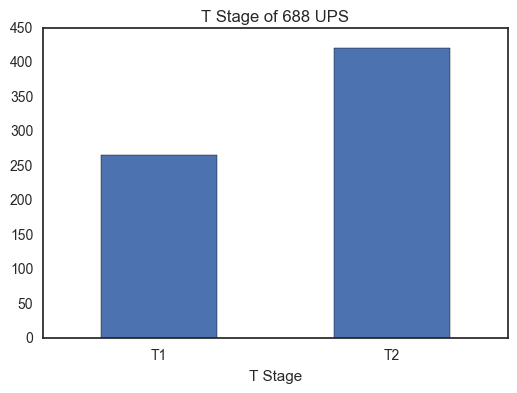

In [141]:
t_stage_map.value_counts().order().plot(kind='bar')
plt.xticks(rotation=0)

plt.title('T Stage of ' + str(int(t_stage_map.value_counts().sum())) + ' UPS')
plt.xlabel('T Stage')

C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


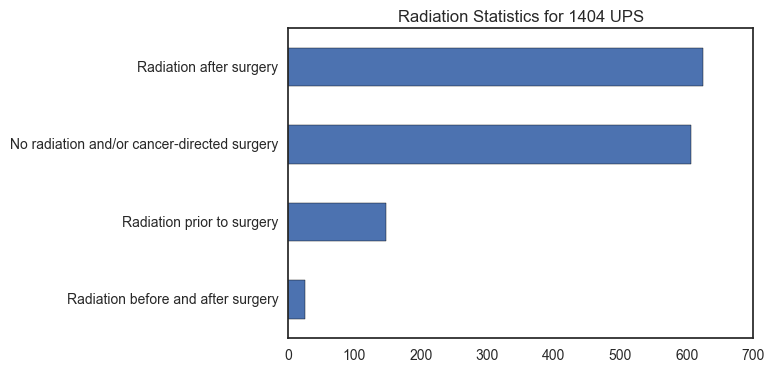

In [163]:
radiation_vc = ups['Radiation sequence with surgery'].value_counts().drop(['Intraoperative rad with other rad before/after surgery', 'Sequence unknown, but both were given', 'Intraoperative radiation'])
radiation_vc.order().plot(kind='barh')

plt.title('Radiation Statistics for ' + str(sum(radiation_vc)) + ' UPS')

In [42]:
spread_vc = ups['SEER historic stage A'].value_counts()

(-1.0, 1.0, -1.0, 1.0)

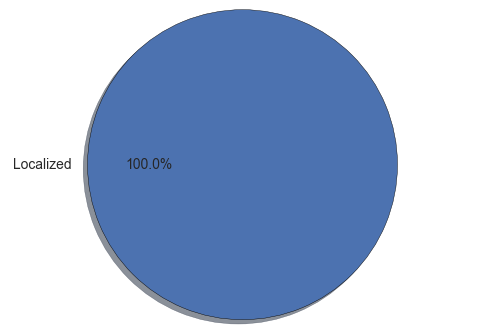

In [43]:
labels = spread_vc.index.values
fracs = spread_vc.values
colors = sns.color_palette("deep", 3)

pie(fracs, labels=labels, shadow=True, colors=colors, autopct='%1.1f%%')
plt.axis('equal')

### Survival Analysis

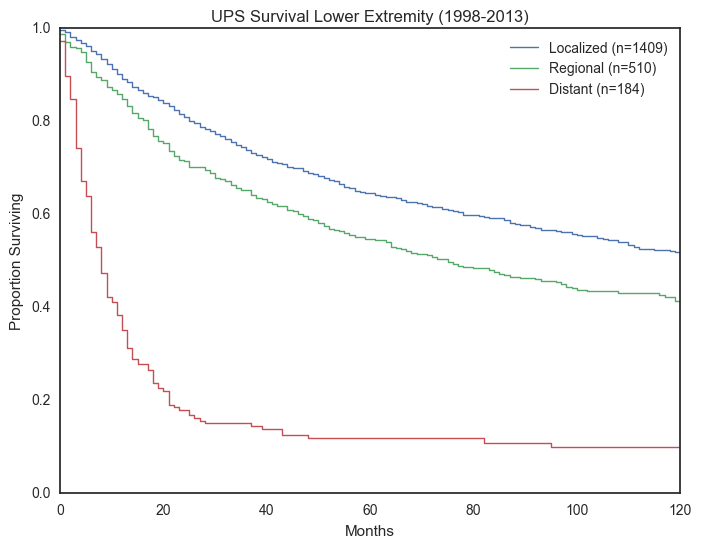

In [51]:
fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(1,1,1)

data = filt_ups.set_index('SEER historic stage A').ix['Localized']
kmf.fit(data['Survival_months'], data['censored'], label='Localized (n=' + str(len(data)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)


data2 = filt_ups.set_index('SEER historic stage A').ix['Regional']
kmf.fit(data2['Survival_months'], data2['censored'], label='Regional (n=' + str(len(data2)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

data3 = filt_ups.set_index('SEER historic stage A').ix['Distant']
kmf.fit(data3['Survival_months'], data3['censored'], label='Distant (n=' + str(len(data3)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

plt.xlim([0,120])
plt.ylim([0,1])

plt.title('UPS Survival Lower Extremity (1998-2013)')
plt.xlabel('Months')
plt.ylabel('Proportion Surviving')


In [56]:
localized_ups = filt_ups[filt_ups['SEER historic stage A'] == 'Localized']

Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.02194 |              5.251 |      Reject Null    |        True       


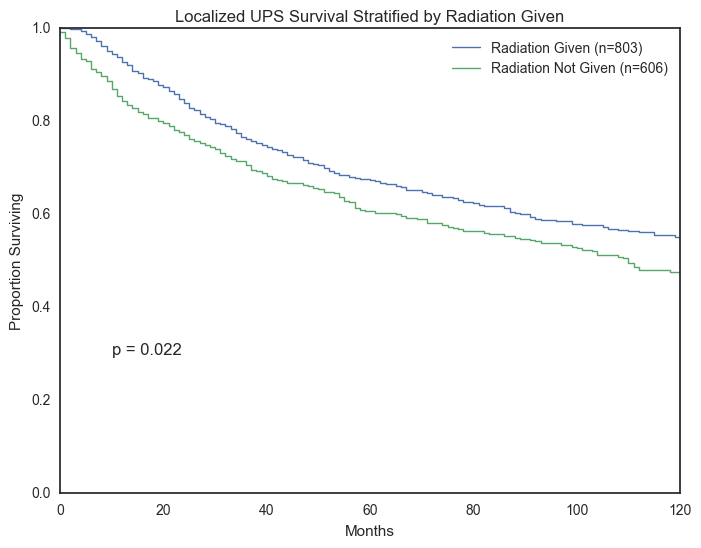

In [57]:
non_rad_df = localized_ups[localized_ups['Radiation sequence with surgery'] == 'No radiation and/or cancer-directed surgery']
rad_df = localized_ups[localized_ups['Radiation sequence with surgery'] != 'No radiation and/or cancer-directed surgery']

fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(1,1,1)

data = rad_df
kmf.fit(data['Survival_months'], data['censored'], label='Radiation Given (n=' + str(len(data)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

data2 = non_rad_df
kmf.fit(data2['Survival_months'], data2['censored'], label='Radiation Not Given (n=' + str(len(data2)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

plt.xlim([0,120])
plt.ylim([0,1])

results = logrank_test(data['Survival_months'], data2['Survival_months'], data['censored'], data2['censored'], alpha=.95 )
results.print_summary()

plt.title('Localized UPS Survival Stratified by Radiation Given')
plt.xlabel('Months')
plt.ylabel('Proportion Surviving')
plt.text(10, 0.3, 'p = ' + '{0:.3f}'.format(results.p_value), size=12)


### Getting T Stage

In [133]:
concat_t_stage = (ups['Derived AJCC T, 7th ed (2010+)'] + ups['Derived AJCC T, 6th ed (2004+)'] + ups['T value - based on AJCC 3rd (1988-2003)']).dropna()

def getTStage(line):
    if line == np.nan:
        return np.nan
    m = re.match('.*(T[0-9]).*', line)
    if m == None:
        return np.nan
    else:
        return m.group(1)
    
t_stage_map = concat_t_stage.map(getTStage).dropna()

In [59]:
t1_pts = t_stage_map[t_stage_map == 'T1'].index.values
t2_pts = t_stage_map[t_stage_map == 'T2'].index.values

Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |             32.866 |      Reject Null    |        True       


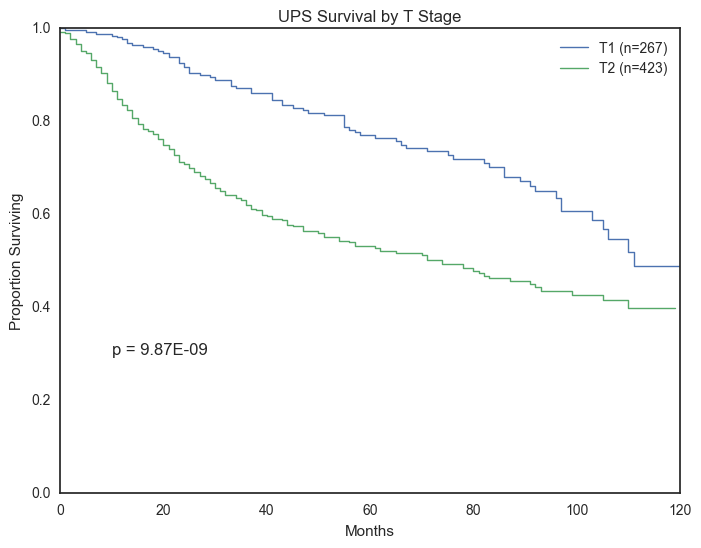

In [60]:
fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(1,1,1)

data = filt_ups.ix[t1_pts]
kmf.fit(data['Survival_months'], data['censored'], label='T1 (n=' + str(len(data)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

data2 = filt_ups.ix[t2_pts]
kmf.fit(data2['Survival_months'], data2['censored'], label='T2 (n=' + str(len(data2)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

plt.xlim([0,120])
plt.ylim([0,1])

results = logrank_test(data['Survival_months'], data2['Survival_months'], data['censored'], data2['censored'], alpha=.95 )
results.print_summary()

plt.title('UPS Survival by T Stage')
plt.xlabel('Months')
plt.ylabel('Proportion Surviving')
plt.text(10, 0.3, 'p = ' + "{:.2E}".format(results.p_value), size=12)

### Age survival curves

In [8]:
l = list(ups.index.values)
set([x for x in l if l.count(x) > 1])

{75083340, 90897478}

Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            110.201 |      Reject Null    |        True       


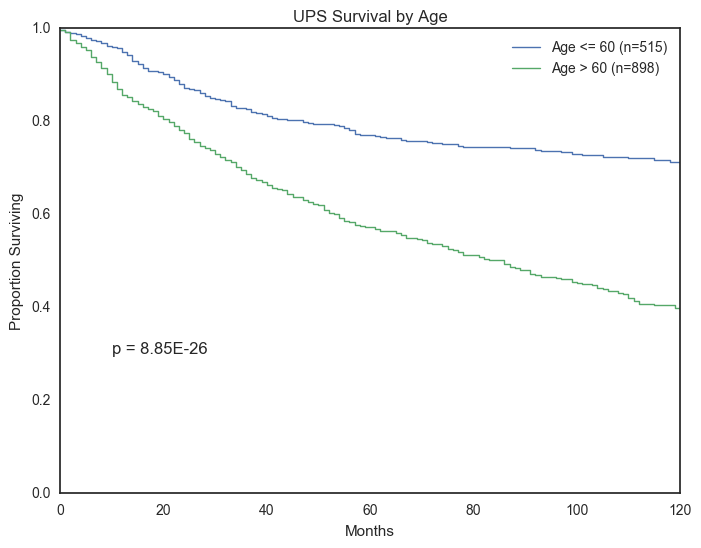

In [83]:
age_cutoff = 60

young_ups = filt_ups[filt_ups.age<=age_cutoff].index.values
old_ups = filt_ups[filt_ups.age>age_cutoff].index.values

fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot(1,1,1)

data = filt_ups.ix[young_ups]
kmf.fit(data['Survival_months'], data['censored'], label='Age <= ' + str(age_cutoff) + ' (n=' + str(len(data)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

data2 = filt_ups.ix[old_ups]
kmf.fit(data2['Survival_months'], data2['censored'], label='Age > ' + str(age_cutoff) + ' (n=' + str(len(data2)) + ")")
kmf.plot(ax=ax, ci_show=False, linewidth=1, show_censors=False)

plt.xlim([0,120])
plt.ylim([0,1])

results = logrank_test(data['Survival_months'], data2['Survival_months'], data['censored'], data2['censored'], alpha=.95 )
results.print_summary()

plt.title('UPS Survival by Age')
plt.xlabel('Months')
plt.ylabel('Proportion Surviving')
plt.text(10, 0.3, 'p = ' + "{:.2E}".format(results.p_value), size=12)

## Building Table

In [198]:
results = []

# Gender
results.append(['Sex', 'Male: ' + str(ups.Sex.value_counts().order()[0]), 'Female: ' + str(ups.Sex.value_counts().order()[1])])

#Age
results.append(['Age', 'Median: ' + str(ups.age.median()), 'Range: ' + str(ups.age.min()) + '-' + str(ups.age.max())])

#T-Stage
results.append(['T-stage', 'T1: ' + str(t_stage_map.value_counts().order()[0]), 'T2: ' + str(t_stage_map.value_counts().order()[1])])

#Tumor Size
size_counts = (tumor_size[tumor_size < 500].order()/10)
results.append(['Tumor Size (cm)', 'Median: ' + str(size_counts.median()), 'Range: ' + str(size_counts.min()) + '-' + str(size_counts.max())])

#Grade
grade_vc = ups.Grade.value_counts().drop('Unknown').order()
results.append(['Histological Grade: ', \
               grade_vc.index[0] + ': ' + str(grade_vc[0]),\
               grade_vc.index[1] + ': ' + str(grade_vc[1]),\
               grade_vc.index[2] + ': ' + str(grade_vc[2]),\
               grade_vc.index[3] + ': ' + str(grade_vc[3])])

#Radiation
radiation_vc = ups['Radiation sequence with surgery'].value_counts().drop(['Intraoperative rad with other rad before/after surgery', 'Sequence unknown, but both were given', 'Intraoperative radiation']).order()
results.append(['Radiation: ', \
               radiation_vc.index[0] + ': ' + str(radiation_vc[0]),\
               radiation_vc.index[1] + ': ' + str(radiation_vc[1]),\
               radiation_vc.index[2] + ': ' + str(radiation_vc[2]),\
               radiation_vc.index[3] + ': ' + str(radiation_vc[3])])

C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)
C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: order is deprecated, use sort_values(...)
C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: order is deprecated, use sort_values(...)
C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: order is deprecated, use sort_values(...)
C:\Users\namqb\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: order is deprecated, use sort_values(...)


In [199]:
import itertools
extract_results = []
for i in itertools.izip_longest(*results):
    extract_results.append(i)
    
df = pd.DataFrame(extract_results).T.set_index(0)

In [200]:
df.to_excel('./Figures/raw_data_usp.xlsx')